In [1]:
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from collections import Counter
import Utils.dataframe as dataframe_helper
import Utils.learning as learning
import mlflow
import spacy

In [3]:
experiment_name = "Count By Word Model"
pd.set_option('display.max_columns', None)
mlflow.set_tracking_uri("../mlruns")
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='../mlruns/746529752663207522', creation_time=1677145153271, experiment_id='746529752663207522', last_update_time=1677145153271, lifecycle_stage='active', name='Count By Word Model', tags={}>

In [4]:
nlp = spacy.load("en_core_web_sm")
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)

Apple Apple PROPN NNP nsubj Xxxxx True False
is be AUX VBZ aux xx True True
looking look VERB VBG ROOT xxxx True False
at at ADP IN prep xx True True
buying buy VERB VBG pcomp xxxx True False
U.K. U.K. PROPN NNP dobj X.X. False False
startup startup NOUN NN dep xxxx True False
for for ADP IN prep xxx True True
$ $ SYM $ quantmod $ False False
1 1 NUM CD compound d False False
billion billion NUM CD pobj xxxx True False


In [5]:
cols = ("text", "lemma", "POS", "explain", "stopword")
rows = []

for t in doc:
    row = [t.text, t.lemma_, t.pos_, spacy.explain(t.pos_), t.is_stop]
    rows.append(row)

df = pd.DataFrame(rows, columns=cols)
    
df

,text,lemma,POS,explain,stopword
0,Apple,Apple,PROPN,proper noun,False
1,is,be,AUX,auxiliary,True
2,looking,look,VERB,verb,False
3,at,at,ADP,adposition,True
4,buying,buy,VERB,verb,False
5,U.K.,U.K.,PROPN,proper noun,False
6,startup,startup,NOUN,noun,False
7,for,for,ADP,adposition,True
8,$,$,SYM,symbol,False
9,1,1,NUM,numeral,False


## Feature Engineering

In [6]:
def feature_engineering_one_hot(df:pd.DataFrame, N:int = None) -> pd.DataFrame:
    with open("../Data/top_word/top_fake_word.txt", "r") as f:
        fake_words = dataframe_helper.string_to_list(f.read())
  
    with open("../Data/top_word/top_genuine_word.txt", "r") as f:
        non_fake_words = dataframe_helper.string_to_list(f.read())

    fake_words = fake_words[:N]
    non_fake_words = non_fake_words[:N]
        
    # KL one hot encoding
    fakeWordOneHot = []
    nonFakeWordOneHot = []

    for content in df['reviewContent']:
        fakeOneHot = ''
        nonFakeOneHot = ''
        words = re.findall(r'\b[A-Za-z][a-z]{2,9}\b', content)

        for word in fake_words:
            if word in words:
                fakeOneHot += '1'
            else:
                fakeOneHot += '0'

        for word in non_fake_words:
            if word in words:
                nonFakeOneHot += '1'
            else:
                nonFakeOneHot += '0'
                
        fakeWordOneHot.append(fakeOneHot)
        nonFakeWordOneHot.append(nonFakeOneHot)
    
    result = pd.DataFrame()
    result['fakeWordsOneHot'] = fakeWordOneHot
    result['nonFakeWordsOneHot'] = nonFakeWordOneHot

    result = dataframe_helper.onehot(result, 'fakeWordsOneHot', fake_words, 'fake')
    result = dataframe_helper.onehot(result, 'nonFakeWordsOneHot', non_fake_words, 'non fake')
    
    result['reviewContent'] = df['reviewContent']
    result['flagged'] = df['flagged']

    return result
    

In [7]:
def feature_engineering_word_count(df:pd.DataFrame, N:int = None) -> pd.DataFrame:
    with open("../Data/top_word/top_fake_word.txt", "r") as f:
        fake_words = dataframe_helper.string_to_list(f.read())
  
    with open("../Data/top_word/top_genuine_word.txt", "r") as f:
        non_fake_words = dataframe_helper.string_to_list(f.read())

    fake_words = fake_words[:N]
    non_fake_words = non_fake_words[:N]
        
    # KL word count
    fakeWordsCount = []
    nonFakeWordsCount = []

    for content in df['reviewContent']:
        words = re.findall(r'\b[A-Za-z][a-z]{2,9}\b', content)
        fakeCount = 0
        nonFakeCount = 0
        for word in words:
            if word in fake_words:
                fakeCount += 1
            elif word in non_fake_words:
                nonFakeCount += 1
        fakeWordsCount.append(fakeCount)
        nonFakeWordsCount.append(nonFakeCount)

    result = pd.DataFrame()
    result['fakeWordsCount'] = fakeWordsCount
    result['nonFakeWordsCount'] = nonFakeWordsCount
    result['reviewContent'] = df['reviewContent']
    result['flagged'] = df['flagged']
    
    return result
    

In [8]:
def feature_engineering_count_by_word(df:pd.DataFrame, N:int = None) -> pd.DataFrame:
    with open("../Data/top_word/top_fake_word.txt", "r") as f:
        fake_words = dataframe_helper.string_to_list(f.read())
  
    with open("../Data/top_word/top_genuine_word.txt", "r") as f:
        non_fake_words = dataframe_helper.string_to_list(f.read())

    fake_words = fake_words[:N]
    non_fake_words = non_fake_words[:N]
        
    # KL one hot encoding
    fakeWordOneHot = []
    nonFakeWordOneHot = []

    for content in df['reviewContent']:
        fakeOneHot = ''
        nonFakeOneHot = ''
        words = re.findall(r'\b[A-Za-z][a-z]{2,9}\b', content)
        words = Counter(words)
        for word in fake_words:
            if word in words:
                fakeOneHot += str(words[word])
            else:
                fakeOneHot += '0'

        for word in non_fake_words:
            if word in words:
                nonFakeOneHot += str(words[word])
            else:
                nonFakeOneHot += '0'
                
        fakeWordOneHot.append(fakeOneHot)
        nonFakeWordOneHot.append(nonFakeOneHot)
    
    result = pd.DataFrame()
    result['fakeWordsOneHot'] = fakeWordOneHot
    result['nonFakeWordsOneHot'] = nonFakeWordOneHot

    result = dataframe_helper.onehot(result, 'fakeWordsOneHot', fake_words, 'fake')
    result = dataframe_helper.onehot(result, 'nonFakeWordsOneHot', non_fake_words, 'non fake')
    
    result['reviewContent'] = df['reviewContent']
    result['flagged'] = df['flagged']

    return result
    

In [9]:
def feature_engineering_cVect(df:pd.DataFrame) -> pd.DataFrame:
    result = pd.DataFrame()
    result['reviewContent'] = df['reviewContent']
    result['flagged'] = df['flagged']
    return result
    

In [10]:
def feature_engineering_combine(df:pd.DataFrame, N:int = None) -> pd.DataFrame:
    nlp = spacy.load("en_core_web_sm")

    with open("../Data/top_word/top_fake_word.txt", "r") as f:
        fake_words = dataframe_helper.string_to_list(f.read())

    with open("../Data/top_word/top_genuine_word.txt", "r") as f:
        non_fake_words = dataframe_helper.string_to_list(f.read())

    fake_words = fake_words[:N]
    non_fake_words = non_fake_words[:N]
        
    # KL one hot encoding
    fakeWordOneHot = []
    nonFakeWordOneHot = []

    # linguistic features
    number_of_words = []
    number_of_verbs = []
    number_of_clauses = []
    average_word_length = []
    pausality = []
    number_of_passive_voice = []
    number_of_self_and_group_reference_terms_used = []
    expressiveness_ratio = []
    lexical_diversity = []
    content_word_diversity = []
    typo_ratio = []
    number_of_spatio_temporal_words = []
    
    for content in df['reviewContent']:
        fakeOneHot = ''
        nonFakeOneHot = ''
        words = re.findall(r'\b[A-Za-z][a-z]{2,9}\b', content)

        for word in fake_words:
            if word in words:
                fakeOneHot += '1'
            else:
                fakeOneHot += '0'

        for word in non_fake_words:
            if word in words:
                nonFakeOneHot += '1'
            else:
                nonFakeOneHot += '0'
                
        fakeWordOneHot.append(fakeOneHot)
        nonFakeWordOneHot.append(nonFakeOneHot)
        
        doc = nlp(content)
        if len(doc) != 0:
            number_of_words.append(len(doc))
            number_of_verbs.append(len([token for token in doc if token.pos_ == "VERB"]))
            number_of_clauses.append(len([token for token in doc if token.dep_ == "ROOT"]))
            average_word_length.append(sum([len(token) for token in doc]) / len(doc))
            pausality.append(len([token for token in doc if token.pos_ == "PUNCT"]) / len(doc))
            number_of_passive_voice.append(len([token for token in doc if token.dep_ == "nsubjpass"]))
            number_of_self_and_group_reference_terms_used.append(len([token for token in doc if token.dep_ == "nsubj"]))
            expressiveness_ratio.append(len([token for token in doc if token.pos_ == "ADJ"]) / len(doc))
            lexical_diversity.append(len(set([token.text for token in doc])) / len(doc))
            content_word_diversity.append(len(set([token.text for token in doc if token.pos_ != "PUNCT"])) / len(doc))
            typo_ratio.append(len([token for token in doc if token.pos_ == "SYM"]) / len(doc))
            number_of_spatio_temporal_words.append(len([token for token in doc if token.pos_ == "ADV"]))
        else:
            number_of_words.append(0)
            number_of_verbs.append(0)
            number_of_clauses.append(0)
            average_word_length.append(0)
            pausality.append(0)
            number_of_passive_voice.append(0)
            number_of_self_and_group_reference_terms_used.append(0)
            expressiveness_ratio.append(0)
            lexical_diversity.append(0)
            content_word_diversity.append(0)
            typo_ratio.append(0)
            number_of_spatio_temporal_words.append(0)

    result = pd.DataFrame()
    result['fakeWordsOneHot'] = fakeWordOneHot
    result['nonFakeWordsOneHot'] = nonFakeWordOneHot
    result = dataframe_helper.onehot(result, 'fakeWordsOneHot', fake_words, 'fake')
    result = dataframe_helper.onehot(result, 'nonFakeWordsOneHot', non_fake_words, 'non fake')
    result['number_of_words'] = number_of_words
    result['number_of_verbs'] = number_of_verbs
    result['number_of_clauses'] = number_of_clauses
    result['average_word_length'] = average_word_length
    result['pausality'] = pausality
    result['number_of_passive_voice'] = number_of_passive_voice
    result['number_of_self_and_group_reference_terms_used'] = number_of_self_and_group_reference_terms_used
    result['expressiveness_ratio'] = expressiveness_ratio
    result['lexical_diversity'] = lexical_diversity
    result['content_word_diversity'] = content_word_diversity
    result['typo_ratio'] = typo_ratio
    result['number_of_spatio_temporal_words'] = number_of_spatio_temporal_words  

    result['reviewContent'] = df['reviewContent']
    result['flagged'] = df['flagged']

    return result
    

In [11]:
def feature_engineering_linguistic(df:pd.DataFrame) -> pd.DataFrame:
    nlp = spacy.load("en_core_web_sm")
    
    number_of_words = []
    number_of_verbs = []
    number_of_clauses = []
    average_word_length = []
    pausality = []
    number_of_passive_voice = []
    number_of_self_and_group_reference_terms_used = []
    expressiveness_ratio = []
    lexical_diversity = []
    content_word_diversity = []
    typo_ratio = []
    number_of_spatio_temporal_words = []
    
    for content in df['reviewContent']:
        doc = nlp(content)
        if len(doc) != 0:
            number_of_words.append(len(doc))
            number_of_verbs.append(len([token for token in doc if token.pos_ == "VERB"]))
            number_of_clauses.append(len([token for token in doc if token.dep_ == "ROOT"]))
            average_word_length.append(sum([len(token) for token in doc]) / len(doc))
            pausality.append(len([token for token in doc if token.pos_ == "PUNCT"]) / len(doc))
            number_of_passive_voice.append(len([token for token in doc if token.dep_ == "nsubjpass"]))
            number_of_self_and_group_reference_terms_used.append(len([token for token in doc if token.dep_ == "nsubj"]))
            expressiveness_ratio.append(len([token for token in doc if token.pos_ == "ADJ"]) / len(doc))
            lexical_diversity.append(len(set([token.text for token in doc])) / len(doc))
            content_word_diversity.append(len(set([token.text for token in doc if token.pos_ != "PUNCT"])) / len(doc))
            typo_ratio.append(len([token for token in doc if token.pos_ == "SYM"]) / len(doc))
            number_of_spatio_temporal_words.append(len([token for token in doc if token.pos_ == "ADV"]))
        else:
            number_of_words.append(0)
            number_of_verbs.append(0)
            number_of_clauses.append(0)
            average_word_length.append(0)
            pausality.append(0)
            number_of_passive_voice.append(0)
            number_of_self_and_group_reference_terms_used.append(0)
            expressiveness_ratio.append(0)
            lexical_diversity.append(0)
            content_word_diversity.append(0)
            typo_ratio.append(0)
            number_of_spatio_temporal_words.append(0)

    result = pd.DataFrame()
    result['number_of_words'] = number_of_words
    result['number_of_verbs'] = number_of_verbs
    result['number_of_clauses'] = number_of_clauses
    result['average_word_length'] = average_word_length
    result['pausality'] = pausality
    result['number_of_passive_voice'] = number_of_passive_voice
    result['number_of_self_and_group_reference_terms_used'] = number_of_self_and_group_reference_terms_used
    result['expressiveness_ratio'] = expressiveness_ratio
    result['lexical_diversity'] = lexical_diversity
    result['content_word_diversity'] = content_word_diversity
    result['typo_ratio'] = typo_ratio
    result['number_of_spatio_temporal_words'] = number_of_spatio_temporal_words  
    result['reviewContent'] = df['reviewContent']
    result['flagged'] = df['flagged']

    return result
    

## Make train dataset

In [12]:
df = dataframe_helper.load_data()
df = dataframe_helper.data_cleaning(df)
# df = feature_engineering_cVect(df)
# df = feature_engineering_one_hot(df)
# df = feature_engineering_word_count(df)
# df = feature_engineering_count_by_word(df,50)
df = feature_engineering_combine(df)

In [13]:
df

food (fake) great (fake) service (fake) place (fake) restaurant (fake)  \
0               0            0              0            1                 1   
1               1            0              0            0                 0   
2               1            0              1            0                 0   
3               0            0              1            1                 0   
4               1            1              0            1                 0   
...           ...          ...            ...          ...               ...   
26953           0            0              0            0                 0   
26954           1            1              0            0                 0   
26955           0            0              1            0                 0   
26956           1            0              0            0                 0   
26957           0            0              0            0                 0   

      best (fake) staff (fake) owner (fake) time (fake) pizza (fake)  \
0               1            0            0           1            0   
1               1            0            0           0            0   
2               0            0            0           0            0   
3               0            0            0           0            0   
4               0            1            0           0            0   
...           ...          ...          ...         ...          ...   
26953           0            0            0           0            0   
26954           0            1            0           0            0   
26955           0            0            0           0            0   
26956           0            0            0           0            0   
26957           0            0            1           0            0   

      love (fake) manager (fake) always (fake) never (fake) would (fake)  \
0               0              0             0            0            1   
1               0              0             0            0            0   
2               0              0             0            0            0   
3               0              0             0            0            0   
4               0              0             0            0            0   
...           ...            ...           ...          ...          ...   
26953           0              1             0            0            0   
26954           0              0             1            0            0   
26955           0              0             0            0            0   
26956           0              0             0            0            0   
26957           0              0             0            0            0   

      atmosphere (fake) told (fake) simply (fake) sushi (fake) asked (fake)  \
0                     0           1             0            0            1   
1                     0           0             0            0            0   
2                     0           0             0            0            0   
3                     0           0             1            0            0   
4                     0           0             0            0            0   
...                 ...         ...           ...          ...          ...   
26953                 0           0             0            0            0   
26954                 0           0             0            0            0   
26955                 0           0             0            0            0   
26956                 0           0             0            0            0   
26957                 0           0             0            0            1   

      went (fake) customer (fake) recommend (fake) waiter (fake)  \
0               1               0                0             0   
1               0               0                0             0   
2               0               0                0             0   
3               0               0             

In [14]:
# 15972, 20728, 25462
df = df.loc[df['number_of_words'] != 0]
df.reset_index(drop=True, inplace=True)

In [15]:
df['flagged'].value_counts()

N    20751
Y     6204
Name: flagged, dtype: int64

In [16]:
over_sampled_df = dataframe_helper.over_sampling(df=df, target='flagged', big_sample='Y', small_sample='N')

Over-Sampling Data
Over-Sampling Complete


In [17]:
over_sampled_df['flagged'].value_counts()

N    20751
Y    20751
Name: flagged, dtype: int64

In [18]:
over_sampled_df.head(5)

,food (fake),great (fake),service (fake),place (fake),restaurant (fake),best (fake),staff (fake),owner (fake),time (fake),pizza (fake),love (fake),manager (fake),always (fake),never (fake),would (fake),atmosphere (fake),told (fake),simply (fake),sushi (fake),asked (fake),went (fake),customer (fake),recommend (fake),waiter (fake),friends (fake),chicago (fake),family (fake),rude (fake),better (fake),wonderful (fake),eat (fake),going (fake),waitress (fake),minutes (fake),worst (fake),people (fake),vietnamese (fake),bad (fake),money (fake),customers (fake),experience (fake),prices (fake),friendly (fake),times (fake),table (fake),back (fake),years (fake),server (fake),wife (fake),italian (fake),fresh (fake),business (fake),birthday (fake),bill (fake),terrible (fake),party (fake),husband (fake),busy (fake),delivery (fake),ever (fake),city (fake),said (fake),bar (fake),week (fake),excellent (fake),amazing (fake),mexican (fake),last (fake),took (fake),new (fake),many (fake),price (fake),pho (fake),quality (fake),horrible (fake),say (fake),hostess (fake),called (fake),fogo (fake),far (fake),first (fake),highly (fake),sunda (fake),authentic (fake),appetizers (fake),favorite (fake),coast (fake),extremely (fake),steak (fake),nana (fake),treated (fake),left (fake),away (fake),evening (fake),make (fake),nice (fake),absolutely (fake),everyone (fake),care (fake),places (fake),persian (fake),town (fake),give (fake),offered (fake),sat (fake),kids (fake),anyone (fake),byob (fake),live (fake),fantastic (fake),work (fake),walked (fake),pay (fake),gave (fake),one (fake),attitude (fake),paid (fake),brazilian (fake),spacca (fake),girlfriend (fake),night (fake),lincoln (fake),management (fake),several (fake),host (fake),hands (fake),nuevo (fake),past (fake),guests (fake),reasonable (fake),soon (fake),brazzaz (fake),wait (fake),korean (fake),tuan (fake),leon (fake),poor (fake),take (fake),visit (fake),call (fake),owners (fake),received (fake),order (fake),every (fake),special (fake),attentive (fake),needs (fake),suggest (fake),average (fake),another (fake),waiting (fake),leave (fake),beef (fake),die (fake),phone (fake),seated (fake),charge (fake),park (fake),wanted (fake),music (fake),must (fake),fabulous (fake),charged (fake),looking (fake),napoli (fake),thanks (fake),tried (fake),even (fake),steaks (fake),waste (fake),card (fake),young (fake),check (fake),entrees (fake),ago (fake),overpriced (fake),job (fake),worse (fake),awful (fake),late (fake),enjoy (fake),guy (fake),visiting (fake),tip (fake),extra (fake),indian (fake),pricey (fake),event (fake),greeted (fake),sent (fake),daughter (fake),weekend (fake),employees (fake),dine (fake),dollars (fake),italy (fake),delivered (fake),brought (fake),main (fake),expensive (fake),ask (fake),understand (fake),loud (fake),apology (fake),person (fake),chris (fake),kabab (fake),managers (fake),making (fake),waited (fake),gets (fake),rolls (fake),credit (fake),incredible (fake),name (fake),speak (fake),dirty (fake),cant (fake),class (fake),sprout (fake),tasteless (fake),total (fake),attention (fake),villa (fake),cake (fake),mastro (fake),real (fake),appetizer (fake),showed (fake),gino (fake),return (fake),today (fake),response (fake),asian (fake),telling (fake),welcoming (fake),jones (fake),frontera (fake),taking (fake),agree (fake),mediocre (fake),pizzas (fake),year (fake),mention (fake),rudely (fake),thats (fake),priced (fake),trying (fake),chao (fake),policy (fake),tell (fake),free (fake),min (fake),cannot (fake),opened (fake),saying (fake),waiters (fake),support (fake),talk (fake),margaritas (fake),organic (fake),needed (fake),waitresses (fake),lemongrass (fake),refused (fake),finally (fake),ready (fake),garcia (fake),paying (fake),bring (fake),lady (fake),correct (fake),change (fake),twice (fake),pleasant (fake),ruth (fake),calo (fake),often (fake),treat (fake),dont (fake),downtown (fake),worth (fake),keep (fake),american (fake),everytime (fake),desert (fake),thank (fake),someone (fake),wontons (fake),taken 

# Model 

In [19]:
rf = RandomForestClassifier(random_state=42, criterion='entropy', max_depth=14, max_features='auto', n_estimators=500)
nb = GaussianNB()

2023/03/01 01:35:26 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/03/01 01:35:26 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


Training Random Forest Model


 14%|█▍        | 1/7 [03:42<22:17, 222.86s/it]

----------------------------------------


 29%|██▊       | 2/7 [05:53<14:04, 168.85s/it]

----------------------------------------


 43%|████▎     | 3/7 [07:48<09:36, 144.20s/it]

----------------------------------------


 57%|█████▋    | 4/7 [09:42<06:36, 132.06s/it]

----------------------------------------


 71%|███████▏  | 5/7 [11:21<04:00, 120.38s/it]

----------------------------------------


 86%|████████▌ | 6/7 [13:00<01:53, 113.06s/it]

----------------------------------------


100%|██████████| 7/7 [14:41<00:00, 125.95s/it]

----------------------------------------


Random Forest Model Results
----------------------------------------
Accuracy Score : 0.7194487278334618
Precision Score : 0.6829188481675392
Recall Score : 0.8109578395181659
F1 Score : 0.7414512834177104
Confusion Matrix : 
[[3291 1938]
 [ 973 4174]]


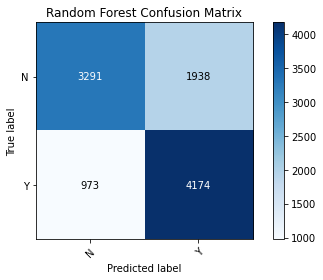

2023/03/01 01:50:15 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/03/01 01:50:15 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


Training Naive Bayes Model


 14%|█▍        | 1/7 [35:11<3:31:11, 2111.87s/it]

----------------------------------------


 29%|██▊       | 2/7 [36:10<1:30:27, 1085.40s/it]

----------------------------------------
Exiting loop


Naive Bayes Model Results
----------------------------------------
Accuracy Score : 0.6633577486507325
Precision Score : 0.6216892289582107
Recall Score : 0.8208665241888479
F1 Score : 0.7075274219207903
Confusion Matrix : 
[[2658 2571]
 [ 922 4225]]


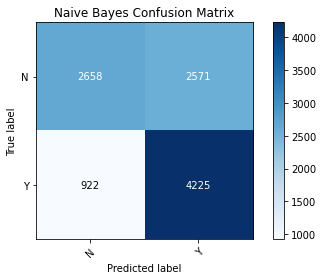

GaussianNB()

In [20]:
learning.semi_supervised_learning(over_sampled_df, experiment_name, df_type='over_sampled', model=rf, threshold=0.7, iterations=7, algorithm='Random Forest', target_column='flagged', log=True)
learning.semi_supervised_learning(over_sampled_df, experiment_name, df_type='over_sampled', model=nb, threshold=0.7, iterations=7, algorithm='Naive Bayes', target_column='flagged', log=True)